# 📊 Multi-Device Anomaly Detection Pipeline
**Improved Feature Mapping for Varying Sensor Structures**


Processing device: bale_counter

⚠️ bale_counter - No numerical sensor features defined for analysis.

Processing device: hatch_status

⚠️ hatch_status - No numerical sensor features defined for analysis.

Processing device: motor_monitor

motor_monitor - Using features: ['power', 'rpm', 'temperature', 'vibration']
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Threshold for ../test_cases/saved_models/lstm_off.h5: 0.043861


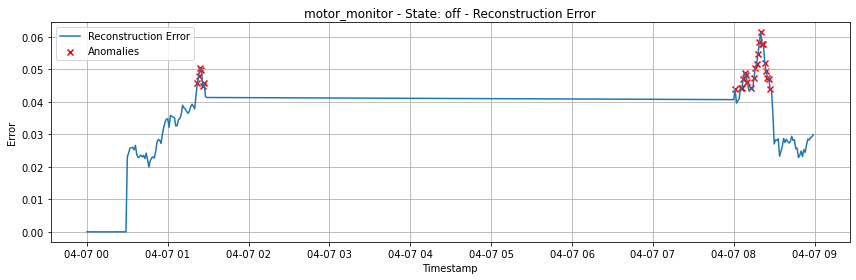

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
Threshold for ../test_cases/saved_models/lstm_idle.h5: 0.040096


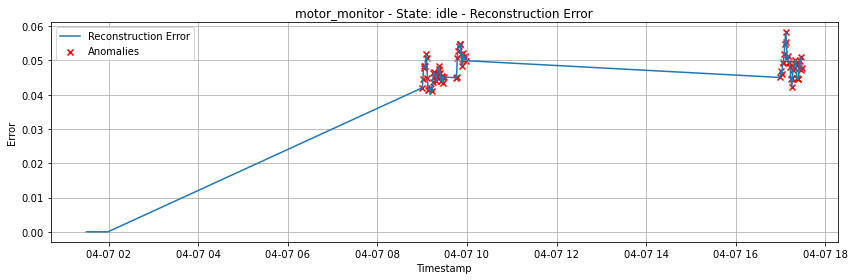

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Threshold for ../test_cases/saved_models/lstm_run.h5: 10.864813


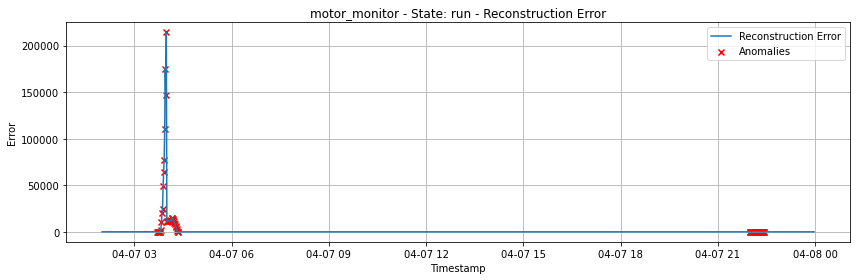


🔍 Classification Report for motor_monitor:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       150
 Overheating       0.00      0.00      0.00         1
Power_outage       1.00      1.00      1.00        18

    accuracy                           0.99       169
   macro avg       0.66      0.67      0.67       169
weighted avg       0.99      0.99      0.99       169



c:\Users\Thomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thomas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


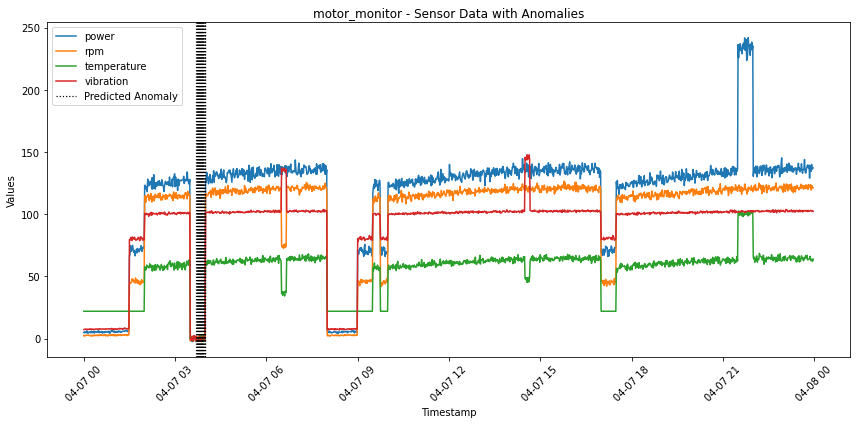


Processing device: output_sensor

⚠️ output_sensor - No numerical sensor features defined for analysis.

Processing device: temperature_sensor

⚠️ temperature_sensor - No numerical sensor features defined for analysis.

✅ Processing complete for all devices!


In [1]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

# Paths
DEVICES_DATA_PATH = "../src/devices_data/"
SAVED_MODELS_PATH = "../test_cases/saved_models/"
MODEL_PATHS = {
    'run': "lstm_run.h5",
    'idle': "lstm_idle.h5",
    'off': "lstm_off.h5"
}

# Refined feature map based on actual uploaded data
DEVICE_FEATURE_MAP = {
    "motor_monitor": ['power', 'rpm', 'temperature', 'vibration'],
    "bale_counter": [],
    "hatch_status": [],
    "output_sensor": [],
    "temperature_sensor": []
}

def get_device_files():
    device_files = []
    for file in os.listdir(DEVICES_DATA_PATH):
        if file.endswith("_unified.csv"):
            device_type = file.split('_')[0] + '_' + file.split('_')[1]
            device_files.append((device_type, file))
    return device_files

def create_sequences(data, seq_length=30):
    return np.array([data.iloc[i:i+seq_length].values for i in range(len(data)-seq_length)])

def detect_state_anomalies(df_state, model_path, feature_cols):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_state[feature_cols])
    sequences = create_sequences(pd.DataFrame(scaled))
    
    model = load_model(model_path, compile=False)
    reconstructions = model.predict(sequences)
    errors = np.mean((reconstructions - sequences[:, -reconstructions.shape[1]:, :]) ** 2, axis=(1, 2))
    
    hist, bins = np.histogram(errors, bins=10000)
    mode_index = np.argmax(hist)
    threshold = (bins[mode_index] + bins[mode_index + 1]) / 2
    print(f"Threshold for {model_path}: {threshold:.6f}")
    
    flags = np.array([False] * len(df_state))
    flags[30:len(errors)+30] = errors > threshold
    df_state['reconstruction_error'] = [0.0]*30 + errors.tolist()
    df_state['is_anomaly'] = flags
    return df_state

def process_device(device_type, csv_file):
    print(f"\n{'='*50}")
    print(f"Processing device: {device_type}")
    print(f"{'='*50}\n")
    
    try:
        df = pd.read_csv(os.path.join(DEVICES_DATA_PATH, csv_file))
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        
        expected_features = DEVICE_FEATURE_MAP.get(device_type, [])
        if not expected_features:
            print(f"⚠️ {device_type} - No numerical sensor features defined for analysis.")
            return None

        available_features = [col for col in expected_features if col in df.columns]
        if not available_features:
            print(f"⚠️ {device_type} - None of the expected features found in data.")
            return None
        
        print(f"{device_type} - Using features: {available_features}")
        df_all = pd.DataFrame()

        for state in df['state'].unique():
            df_state = df[df['state'] == state].copy()
            model_path = os.path.join(SAVED_MODELS_PATH, MODEL_PATHS.get(state))
            
            if model_path and os.path.exists(model_path):
                df_state = detect_state_anomalies(df_state, model_path, available_features)
                df_all = pd.concat([df_all, df_state])
                
                plt.figure(figsize=(12, 4))
                plt.plot(df_state['timestamp'], df_state['reconstruction_error'], label='Reconstruction Error')
                plt.scatter(
                    df_state[df_state['is_anomaly']]['timestamp'],
                    df_state[df_state['is_anomaly']]['reconstruction_error'],
                    color='red', label='Anomalies', marker='x'
                )
                plt.title(f"{device_type} - State: {state} - Reconstruction Error")
                plt.xlabel("Timestamp")
                plt.ylabel("Error")
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

        if df_all.empty:
            return None
        
        df_all = df_all.sort_values('timestamp').reset_index(drop=True)
        df_encoded = pd.get_dummies(df_all, columns=["state"])
        for col in ["state_off", "state_run", "state_idle"]:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        rf_model_path = os.path.join(SAVED_MODELS_PATH, "random_forest.pkl")
        if os.path.exists(rf_model_path):
            rf_model = joblib.load(rf_model_path)
            anomaly_df = df_encoded[df_encoded["is_anomaly"] == True].copy()
            features = available_features + ["state_idle", "state_off", "state_run"]

            if not anomaly_df.empty:
                if 'label' in anomaly_df.columns:
                    X_anomaly = anomaly_df[features]
                    y_true = anomaly_df['label']
                    y_pred = rf_model.predict(X_anomaly)
                    print(f"\n🔍 Classification Report for {device_type}:")
                    print(classification_report(y_true, y_pred))
                else:
                    print(f"⚠️ {device_type}: 'label' column not found. Cannot compute classification report.")

                plt.figure(figsize=(12, 6))
                for feature in available_features:
                    plt.plot(df_all['timestamp'], df_all[feature], label=feature)

                pred_anomaly_idx = anomaly_df.index[y_pred != "Normal"] if 'label' in anomaly_df.columns else anomaly_df.index
                for ts in anomaly_df.loc[pred_anomaly_idx, 'timestamp']:
                    plt.axvline(x=ts, color='black', linestyle=':', linewidth=1.2,
                               label='Predicted Anomaly' if 'Predicted Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")

                plt.title(f'{device_type} - Sensor Data with Anomalies')
                plt.xlabel('Timestamp')
                plt.ylabel('Values')
                plt.legend()
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

        return df_all

    except Exception as e:
        print(f"Error processing {device_type}: {str(e)}")
        return None

# Main execution
device_files = get_device_files()
all_results = {}

for device_type, csv_file in device_files:
    result = process_device(device_type, csv_file)
    if result is not None:
        all_results[device_type] = result

print("\n✅ Processing complete for all devices!")
